# Quantum benchmark

## I - Introduction

## II - Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from skpp import ProjectionPursuitRegressor

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [5]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [6]:
# Read out CSV

df = pd.read_csv('fraud_detection_bank_dataset.csv', sep=',')

In [9]:
df.shape

(20468, 114)

In [10]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [11]:
df = df.drop(['Unnamed: 0'], axis = 1)
df_labels = df['targets']
df.drop(['targets'],axis = 1,inplace = True)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

## Quantum Approaches

In [13]:
np.unique(df_labels)

array([0, 1])

In [14]:
cols = ['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19','col_20', 'col_21', 'col_35', 
        'col_51', 'col_52', 'col_53', 'col_70','col_71','col_7', 'col_22', 'col_54', 'col_56']

In [15]:
X_train = X_train.drop(cols, axis=1)
X_test = X_test.drop(cols, axis=1)

In [16]:
np.shape(X_train)

(16374, 93)

In [17]:
skpp = ProjectionPursuitRegressor(r=2, fit_type='spline', opt_level='medium').fit(X_train, y_train)

In [18]:
# SKPP validate transformation (using train fit)
x_train_skpp = skpp.transform(X_train)
x_test_skpp = skpp.transform(X_test)

In [19]:
# Arrays to dataframe for join in a single df
x_train_skpp = pd.DataFrame(x_train_skpp)
x_test_skpp = pd.DataFrame(x_test_skpp)

In [20]:
# Second standard scaler normalization (using train fit)
std_scale = StandardScaler().fit(x_train_skpp)
X_train_skpp_norm = std_scale.transform(x_train_skpp)
x_test_skpp_norn = std_scale.transform(x_test_skpp)
#x_validate_lda_n = std_scale.transform(x_validate_skpp)

In [21]:
# Dimensions definition for QML
n_dim = len(x_train_skpp.columns)
n_dim

2

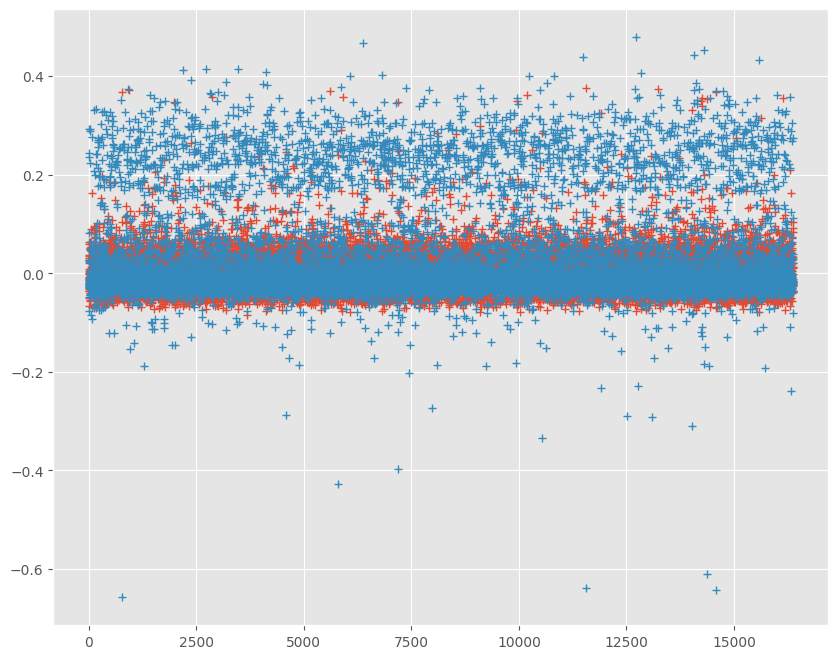

In [22]:
plt.figure(figsize=(10,8))
plt.plot(x_train_skpp, '+')


## Split train test 

In [23]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     X_train_skpp_norm, y_train, test_size=0.2, random_state=22)

# Normalize

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [24]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [28]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
svc.fit(sample_train, label_train)
score = svc.score(sample_test, label_test)

print(f"Callable kernel classification test score: {score}")

In [27]:
result_predict = svc.predict(sample_test)

In [28]:
print(metrics.classification_report(label_test,result_predict))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       154
           1       0.53      0.20      0.29        46

    accuracy                           0.78       200
   macro avg       0.66      0.57      0.58       200
weighted avg       0.74      0.78      0.73       200



In [33]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in tqdm(_models):
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(100*_array.mean(), 2))
            stds.append(round(100*_array.std(), 2))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [34]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('qsvc', svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']

In [36]:
df_results = pd.DataFrame()
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)
df_results 

100%|████████████████████████████████████████████| 6/6 [52:21<00:00, 523.61s/it]

                fit_time  score_time  test_precision  test_recall  test_f1  \
LR mean (%)      0.00119     0.00124         0.88694      0.55521  0.67501   
LR std (%)       0.00060     0.00025         0.09873      0.11474  0.09798   
KNN mean (%)     0.00030     0.00194         0.79347      0.70928  0.74461   
KNN std (%)      0.00005     0.00013         0.08864      0.10804  0.08872   
CART mean (%)    0.00087     0.00116         0.70612      0.67641  0.68696   
CART std (%)     0.00008     0.00013         0.06905      0.10398  0.07878   
NB mean (%)      0.00027     0.00111         0.89067      0.43287  0.57444   
NB std (%)       0.00003     0.00008         0.07183      0.10822  0.09430   
SVM mean (%)     0.00261     0.00179         0.89627      0.53655  0.66271   
SVM std (%)      0.00013     0.00012         0.09813      0.11916  0.10199   
qsvc mean (%)  259.82441    54.32464         0.54833      0.10200  0.17125   
qsvc std (%)     1.92263     0.22567         0.20662      0.0363

In [37]:
df_results

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy,test_matthews_corrcoef,test_balanced_accuracy
LR mean (%),0.00119,0.00124,0.88694,0.55521,0.67501,0.86875,0.63058,0.76612
LR std (%),0.00060,0.00025,0.09873,0.11474,0.09798,0.03319,0.10162,0.05778
KNN mean (%),0.00030,0.00194,0.79347,0.70928,0.74461,0.88125,0.67241,0.82377
KNN std (%),0.00005,0.00013,0.08864,0.10804,0.08872,0.03075,0.09945,0.05547
CART mean (%),0.00087,0.00116,0.70612,0.67641,0.68696,0.84875,0.59034,0.79138
CART std (%),0.00008,0.00013,0.06905,0.10398,0.07878,0.02465,0.08442,0.04950
NB mean (%),0.00027,0.00111,0.89067,0.43287,0.57444,0.84250,0.54584,0.70724
NB std (%),0.00003,0.00008,0.07183,0.10822,0.09430,0.03072,0.08516,0.05240
SVM mean (%),0.00261,0.00179,0.89627,0.53655,0.66271,0.86625,0.62319,0.75850
SVM std (%),0.00013,0.00012,0.09813,0.11916,0.10199,0.03356,0.10375,0.05964


## Pennylane

In [38]:
from pennylane import numpy as np

In [39]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [40]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [41]:
circuit(weights_init, sample_train[0])

tensor(-0.09015829, requires_grad=True)

In [42]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [43]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [44]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [45]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [46]:
pd.Series(label_test).value_counts()

0    154
1     46
Name: targets, dtype: int64

In [47]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.89034686, requires_grad=True), tensor(0.08663997, requires_grad=True)], Y = -1
X = [tensor(0.35602719, requires_grad=True), tensor(-0.48564519, requires_grad=True)], Y = -1
X = [tensor(-0.2078483, requires_grad=True), tensor(-0.31688344, requires_grad=True)], Y = -1
X = [tensor(0.54692588, requires_grad=True), tensor(-0.57623391, requires_grad=True)], Y = -1
X = [tensor(0.54821712, requires_grad=True), tensor(-0.19193911, requires_grad=True)], Y = -1


In [48]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [49]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.8704147 | f1: 0.1501976 
Iter:     2 | Cost: 0.8466560 | f1: 0.1370968 
Iter:     3 | Cost: 0.8957544 | f1: 0.1255230 
Iter:     4 | Cost: 0.8953898 | f1: 0.1350211 
New best
Iter:     5 | Cost: 0.8916812 | f1: 0.1576763 
New best
Iter:     6 | Cost: 0.9211586 | f1: 0.1916667 
New best
Iter:     7 | Cost: 0.8213404 | f1: 0.1924686 
New best
Iter:     8 | Cost: 0.7701475 | f1: 0.2459016 
Iter:     9 | Cost: 0.7172029 | f1: 0.2083333 
Iter:    10 | Cost: 0.7128270 | f1: 0.1772152 
Iter:    11 | Cost: 0.7537682 | f1: 0.1646091 
New best
Iter:    12 | Cost: 0.7793589 | f1: 0.2905405 
Iter:    13 | Cost: 0.7285214 | f1: 0.1945525 
Iter:    14 | Cost: 0.6837354 | f1: 0.1350211 
Iter:    15 | Cost: 0.6707374 | f1: 0.1344538 
Iter:    16 | Cost: 0.6659609 | f1: 0.1500000 
Iter:    17 | Cost: 0.6747343 | f1: 0.1833333 
Iter:    18 | Cost: 0.6643353 | f1: 0.2348178 
Iter:    19 | Cost: 0.6387732 | f1: 0.2560000 
Iter:    20 | Cost: 0.6258875 | f1: 0.2745098 
New be

In [50]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [51]:
pd.Series(Yte).value_counts()

-1.0    154
 1.0     46
dtype: int64

In [52]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.4350651986491049, Accuracy: 84.0%


In [53]:
print(metrics.classification_report(Yte,predictions))

              precision    recall  f1-score   support

        -1.0       0.98      0.81      0.89       154
         1.0       0.60      0.93      0.73        46

    accuracy                           0.84       200
   macro avg       0.79      0.87      0.81       200
weighted avg       0.89      0.84      0.85       200



In [69]:
print(metrics.classification_report(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       1.00      0.82      0.90       187
         1.0       0.28      1.00      0.44        13

    accuracy                           0.83       200
   macro avg       0.64      0.91      0.67       200
weighted avg       0.95      0.83      0.87       200



In [54]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    ''')



    Precision: 93.48%
    Recall: 59.72%
    f1: 72.88%
    Accuracy: 84.0%
    Balanced accuracy: 78.69%
    Matthew corcorref: 65.45%
    


In [56]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 1 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = accuracy(Y, predictions)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.9591679 | Accuracy: 0.6850000 
New best
Iter:     2 | Cost: 0.8119139 | Accuracy: 0.7300000 
New best
Iter:     3 | Cost: 0.7352352 | Accuracy: 0.7375000 
Iter:     4 | Cost: 0.7666034 | Accuracy: 0.7350000 
Iter:     5 | Cost: 0.7994900 | Accuracy: 0.7362500 
Iter:     6 | Cost: 0.7946886 | Accuracy: 0.7350000 
Iter:     7 | Cost: 0.7639406 | Accuracy: 0.7350000 
Iter:     8 | Cost: 0.7319485 | Accuracy: 0.7350000 
Iter:     9 | Cost: 0.7053591 | Accuracy: 0.7350000 
New best
Iter:    10 | Cost: 0.6383776 | Accuracy: 0.7450000 
New best
Iter:    11 | Cost: 0.5972009 | Accuracy: 0.7650000 
New best
Iter:    12 | Cost: 0.6066362 | Accuracy: 0.8337500 
New best
Iter:    13 | Cost: 0.6178081 | Accuracy: 0.8487500 
New best
Iter:    14 | Cost: 0.5677686 | Accuracy: 0.8562500 
Iter:    15 | Cost: 0.4963915 | Accuracy: 0.8512500 
New best
Iter:    16 | Cost: 0.4880981 | Accuracy: 0.8612500 
Iter:    17 | Cost: 0.4592306 | Accuracy: 0.8525000 
Iter:    18 | Cost

In [57]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.5212546981437339, Accuracy: 78.0%


In [58]:
print(metrics.classification_report(Yte, predictions))

              precision    recall  f1-score   support

        -1.0       0.89      0.81      0.85       154
         1.0       0.51      0.67      0.58        46

    accuracy                           0.78       200
   macro avg       0.70      0.74      0.71       200
weighted avg       0.80      0.78      0.79       200



In [59]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 67.39%
    Recall: 50.82%
    f1: 57.94%
    Accuracy: 77.5%
    Balanced accuracy: 70.01%
    Matthew corcorref: 43.79%
    
